In [1]:
import numpy as np
from numpy import pi,cos,sin
i = np.array([[1, 0], [0, 1]])
x = np.array([[0, 1], [1, 0]])
y = np.array([[0, -1j], [1j, 0]])
z = np.array([[1, 0], [0, -1]])
cx = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
ry = lambda theta: np.array([[cos(theta/2), -sin(theta/2)], [sin(theta/2), cos(theta/2)]])
rx = lambda theta: np.array([[cos(theta/2), -1j*sin(theta/2)], [-1j*sin(theta/2), cos(theta/2)]])
rz = lambda theta: np.array([[np.exp(-1j*theta/2), 0], [0, np.exp(1j*theta/2)]])

In [2]:
from sojo.stabilizer import StabilizerGenerator, PauliTerm, PauliWord
stb = StabilizerGenerator(2)
stb.ry(np.pi/3, 0)
stb.rx(np.pi/2, 0)
stb.cx([0,1])
stb.t(0)
stb.cx([0,1])
stb.h(0)
stb.rz(np.pi/4, 0)
stb.rx(np.pi/3, 1)
for s in (stb.stabilizers):
    print(s)

[-0.183]*yi + [0.9659]*zi + [0.183]*xi
[0.5]*iz + [-0.866]*iy


In [88]:
K = stb.stabilizers[0]
from sojo.pc import PauliComposer
import jax.numpy as jnp
from jax import vmap
def zipped_list(rows, cols):
    return [list(item) for item in zip(rows, cols)]

batch_indices = []
batch_values = []
for word, value in K.words.items():
	pc = PauliComposer(word, value[0])
	zip_list = zipped_list(pc.get_row(), pc.get_col())
	batch_indices.append(zip_list)
	batch_values.append(pc.get_value())
batch_indices = jnp.array(batch_indices)
batch_values = jnp.array(batch_values)
batch_sparse_matrix = BCOO((batch_values, batch_indices), shape = (len(K.words.items()),2**pc.n,2**pc.n))
def sum_bcoo(tensor):
    return tensor.sum(axis=0)  # Summing along axis 1

# Apply jax.jit to compile the function
jit_sum_bcoo = jax.jit(sum_bcoo)
k = jit_sum_bcoo(batch_sparse_matrix)
print(k.todense())

[[ 0.9659258 +0.j          0.        +0.j          0.18301271+0.18301271j
   0.        +0.j        ]
 [ 0.        +0.j          0.9659258 +0.j          0.        +0.j
   0.18301271+0.18301271j]
 [ 0.18301271-0.18301271j  0.        +0.j         -0.9659258 +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.18301271-0.18301271j  0.        +0.j
  -0.9659258 +0.j        ]]


In [78]:
K.to_matrix_naive()

yi [-0.18301270189221927]


array([[ 0.96592583+0.j       ,  0.        +0.j       ,
         0.1830127 +0.3660254j,  0.        +0.j       ],
       [ 0.        +0.j       ,  0.96592583+0.j       ,
         0.        +0.j       ,  0.1830127 +0.3660254j],
       [ 0.1830127 -0.3660254j,  0.        +0.j       ,
        -0.96592583+0.j       ,  0.        +0.j       ],
       [ 0.        +0.j       ,  0.1830127 -0.3660254j,
         0.        +0.j       , -0.96592583+0.j       ]])

In [50]:
for word, value in K.words.items():
	pc = PauliComposer(word, value[0])
	print(pc.to_matrix())

[[0.+0.j        0.+0.j        0.+0.1830127j 0.+0.j       ]
 [0.+0.j        0.+0.j        0.+0.j        0.+0.1830127j]
 [0.-0.1830127j 0.+0.j        0.+0.j        0.+0.j       ]
 [0.+0.j        0.-0.1830127j 0.+0.j        0.+0.j       ]]
[[ 0.96592583  0.          0.          0.        ]
 [ 0.          0.96592583  0.          0.        ]
 [ 0.          0.         -0.96592583  0.        ]
 [ 0.          0.          0.         -0.96592583]]
[[0.        0.        0.1830127 0.       ]
 [0.        0.        0.        0.1830127]
 [0.1830127 0.        0.        0.       ]
 [0.        0.1830127 0.        0.       ]]


In [86]:

from jax import grad
from jax.experimental import sparse
from jax.experimental.sparse import bcoo_concatenate
# Batched example
import jax
import jax.numpy as jnp
from jax.experimental.sparse import BCOO
batch_indices = jnp.array([
    [[3, 0], [1, 1]],  # First matrix
    [[1, 1], [1, 0]],  # Second matrix
    [[0, 0], [3, 1]],  # First matrix
])

batch_data = jnp.array([
    [10.0, 20.0],  # Data for first matrix
    [30.0, 40.0],  # Data for second matrix
    [110.0, 210.0],  # Data for first matrix
])

batch_shape = (3, 4, 4)  # 4 matrices of shape (2, 2)

batch_sparse_matrix = BCOO((batch_data, batch_indices), shape = batch_shape)
def sum_bcoo(tensor):
    return tensor.sum(axis=0)  # Summing along axis 1

# Apply jax.jit to compile the function
jit_sum_bcoo = jax.jit(sum_bcoo)
k = jit_sum_bcoo(batch_sparse_matrix)
print(batch_sparse_matrix.todense())
print(k.todense())
from jax import vmap

# # pmap parallelizes across devices for even larger batch sizes
parallel_sum_pmap = vmap(lambda b: b.sum(), in_axes = 0)(batch_sparse_matrix)
print(parallel_sum_pmap.todense())
# bcoo_concatenate(batch_sparse_matrix, dimension = 1).todense()

[[[  0.   0.   0.   0.]
  [  0.  20.   0.   0.]
  [  0.   0.   0.   0.]
  [ 10.   0.   0.   0.]]

 [[  0.   0.   0.   0.]
  [ 40.  30.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]]

 [[110.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0. 210.   0.   0.]]]
[[110.   0.   0.   0.]
 [ 40.  50.   0.   0.]
 [  0.   0.   0.   0.]
 [ 10. 210.   0.   0.]]


AttributeError: 'jaxlib.xla_extension.ArrayImpl' object has no attribute 'todense'

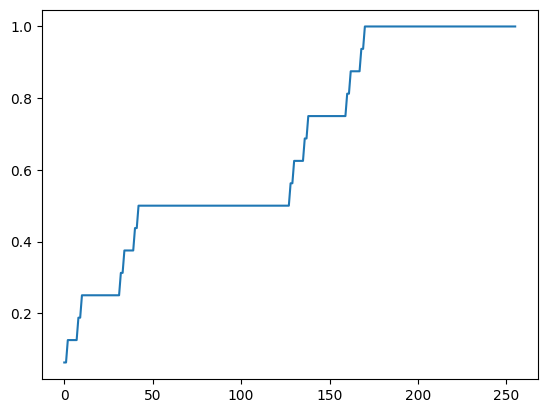

In [7]:
from itertools import product
from sojo.pc import PauliComposer
# Define the set of characters
chars = ['x', 'y', 'z', 'i']
n = 4
# Generate all combinations of length n
combinations = [''.join(p) for p in product(chars, repeat=n)]
xs = np.random.uniform(-2, 2, 4**n)
matrix = np.zeros((2**n, 2**n), dtype=complex)
densities = []
for i, comb in enumerate(combinations):
    matrix += PauliComposer(comb, xs[i]).to_matrix()
    density = np.count_nonzero(matrix) / matrix.size
    densities.append(density)
import matplotlib.pyplot as plt
plt.plot(densities)